

---

# **Imports**

In [313]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from prettytable import PrettyTable

In [314]:
import tensorflow as tf
import tensorflow_hub as hub

In [315]:
print("TF version:", tf.__version__)

TF version: 2.12.0


In [316]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, ReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16,MobileNet

In [317]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [318]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---
# **Data**


In [319]:
main_split_dir ='/content/drive/MyDrive/Image Data Split/'
print(os.listdir(main_split_dir))
train_dir ='/content/drive/MyDrive/Image Data Split/Train/'
print(os.listdir(train_dir))
test_intra_dir ='/content/drive/MyDrive/Image Data Split/Test intra/'
print(os.listdir(test_intra_dir))
test_inter_dir ='/content/drive/MyDrive/Image Data Split/Test inter/'
print(os.listdir(test_inter_dir))

['Train', 'Test intra', 'Test inter']
['Anomaly', 'Normal', 'Poor Quality']
['Normal', 'Anomaly', 'Poor Quality']
['Normal', 'Anomaly', 'Poor Quality']


In [320]:
#train
num_train_normal= len(os.listdir(train_dir+'Normal/'))
num_train_anomaly = len(os.listdir(train_dir+'Anomaly/'))
num_train_poor = len(os.listdir(train_dir+'Poor Quality/'))
Tot_train =  num_train_poor + num_train_anomaly + num_train_normal             

#test intra
num_test_intra_normal = len(os.listdir(test_intra_dir+'Normal/'))
num_test_intra_anomaly = len(os.listdir(test_intra_dir+'Anomaly/'))
num_test_intra_poor = len(os.listdir(test_intra_dir+'Poor Quality/'))
Tot_test_intra =  num_test_intra_normal + num_test_intra_anomaly + num_test_intra_poor

#test inter
num_test_inter_normal = len(os.listdir(test_inter_dir+'Normal/'))
num_test_inter_anomaly = len(os.listdir(test_inter_dir+'Anomaly/'))
num_test_inter_poor = len(os.listdir(test_inter_dir+'Poor Quality/'))
Tot_test_inter =  num_test_inter_normal + num_test_inter_anomaly + num_test_inter_poor

#table stat general
t = PrettyTable(['Class','Train','Test intra','Test inter'])
t.add_row(['Normal',num_train_normal,num_test_intra_normal,num_test_inter_normal])
t.add_row(['Anomaly',num_train_anomaly,num_test_intra_anomaly,num_test_inter_anomaly])
t.add_row(['Poor Quality',num_train_poor,num_test_intra_poor,num_test_inter_poor])
t.add_row(['Total',Tot_train,Tot_test_intra,Tot_test_inter])
print(t)

+--------------+-------+------------+------------+
|    Class     | Train | Test intra | Test inter |
+--------------+-------+------------+------------+
|    Normal    |  1303 |    241     |    241     |
|   Anomaly    |  469  |    136     |    106     |
| Poor Quality |  177  |     2      |     8      |
|    Total     |  1949 |    379     |    355     |
+--------------+-------+------------+------------+


In [321]:
import pandas as pd
def create_df(directory):
    file_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.endswith('.png'): # or any other image format
                    file_path = os.path.join(class_path, file_name)
                    file_paths.append(file_path)
                    labels.append(class_folder)
    df = pd.DataFrame({'file_path': file_paths, 'label': labels})
    return df

# Create DataFrames for train, validation, and test sets
train_df = create_df(train_dir)
test_intra_df = create_df(test_intra_dir)
test_inter_df = create_df(test_inter_dir)

# Print the number of images and classes in each set
print('Train set:', len(train_df), train_df['label'].nunique())
print('Test intra set:', len(test_intra_df), test_intra_df['label'].nunique())
print('Test inter set:', len(test_inter_df), test_inter_df['label'].nunique())

Train set: 1949 3
Test intra set: 379 3
Test inter set: 355 3


In [322]:
# Create DataFrames for train, validation, and test sets
train_aug_df = create_df('/content/drive/MyDrive/Augmented data/')

# Print the number of images and classes in each set
print('Augmented Train spectograms:', len(train_aug_df), train_aug_df['label'].nunique())


Augmented Train spectograms: 1365 2


In [323]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

In [324]:
print('train set:', len(train), train['label'].nunique())
print('valid set:', len(valid), valid['label'].nunique())

train set: 1559 3
valid set: 390 3


In [325]:
train_df = [train , train_aug_df ]
train_df = pd.concat(train_df)

In [326]:
anom_nbr =len(train_df[train_df.label == 'Anomaly'])

In [327]:
norom_nbr = len(train_df[train_df.label == 'Normal'])

In [328]:
poor_nbr = len(train_df[train_df.label == 'Poor Quality'])

In [329]:
anom_nbr

1206

In [330]:
norom_nbr

1045

In [331]:
poor_nbr

673



---

# **Datagens and smote**

In [332]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [333]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen  = ImageDataGenerator(rescale = 1./255)

In [334]:
with tf.device(device_name):
  # Load the pre-trained MobileNet model without the top layer
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [335]:
with tf.device(device_name):
  number_of_layers = len(base_model.layers)

In [336]:
print(number_of_layers)

19


In [337]:
# Freeze the % layers in the base model
percent = 0.45
number_of_layers_to_freeze =  int(number_of_layers * percent)
with tf.device(device_name):
  # Freeze some layers
  for layer in base_model.layers[:number_of_layers_to_freeze]:
      layer.trainable = False

In [338]:
# description of the model
with tf.device(device_name):
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(Dense(3, activation='softmax'))

In [339]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_12 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_13 (Bat  (None, 512)             

In [340]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming your DataFrame is called df and the target column is called 'class'
class_labels = train_df['label'].unique()
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])

print("Class labels:", class_labels)
print("Class weights:", class_weights)

Class labels: ['Normal' 'Poor Quality' 'Anomaly']
Class weights: [0.93269537 1.4482417  0.80818132]


In [341]:
class_weights_dict = dict(zip([2,0,1], [1.8,3,1.5]))   #2 0 1 
print("Class weights dictionary:", class_weights_dict)

Class weights dictionary: {2: 1.8, 0: 3, 1: 1.5}


In [342]:
with tf.device(device_name):
  model.compile(
    optimizer="adamax",
    loss='categorical_crossentropy',
    metrics=['acc'])

In [343]:
# callbacks
from tensorflow.keras import callbacks
with tf.device(device_name):
  early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

  plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

  checkpoint = callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/best_model.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', verbose=1
)

In [344]:
# Define the number of folds for cross-validation
num_folds = 5
# Define the cross-validation method
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [345]:
# Initialize lists to store the training and validation metrics for each fold
train_losses, train_accs, val_losses, val_accs = [], [], [], []

In [346]:
# Loop over the folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
    # Print the fold number
    print('Fold', fold+1)
    
    training_set = train_datagen.flow_from_dataframe(
            train_df.iloc[train_idx],
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            batch_size = 8,
            class_mode = 'categorical')
    
    validation_set = val_datagen.flow_from_dataframe(
            train_df.iloc[val_idx],
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            batch_size = 8,
            class_mode = 'categorical')

    # Train the model on the training data for this fold
    history = model.fit(training_set, epochs=10, batch_size = 8,
                        steps_per_epoch=len(training_set),
                        validation_data=validation_set, 
                        validation_steps=len(validation_set), 
                        callbacks=[early_stopping, plateau,checkpoint],
                        class_weight= class_weights_dict)
    
    # Get the training and validation metrics for this fold from the history object
    train_loss = history.history['loss'][-1]
    train_acc = history.history['acc'][-1]
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_acc'][-1]
    
    # Append the training and validation metrics to the respective lists
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print the training and validation metrics for this fold
    print(f"Training Loss: {train_loss:.4f} - Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.4f}")
   

Fold 1
Found 2339 validated image filenames belonging to 3 classes.
Found 585 validated image filenames belonging to 3 classes.
Epoch 1/10
293/293 [==============================] - ETA: 0s - loss: 10.2284 - acc: 0.4446
Epoch 1: val_loss improved from inf to 10.83383, saving model to /content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/best_model.h5
293/293 [==============================] - 36s 102ms/step - loss: 10.2284 - acc: 0.4446 - val_loss: 10.8338 - val_acc: 0.4034 - lr: 0.0010
Epoch 2/10
293/293 [==============================] - ETA: 0s - loss: 8.5196 - acc: 0.4895
Epoch 2: val_loss improved from 10.83383 to 7.36679, saving model to /content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/best_model.h5
293/293 [==============================] - 31s 107ms/step - loss: 8.5196 - acc: 0.4895 - val_loss: 7.3668 - val_acc: 0.3402 - lr: 0.0010
Epoch 3/10
293/293 [==============================] - ETA: 0s - loss: 7.4537 - acc: 0.5195
Epoch 3: val_loss did not impr

In [347]:
import pickle
# sauvgarder le model
model.save('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/last_epoch_model.h5')
# save history
with open('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

**Test**

In [348]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve ,auc
import seaborn as sns

In [349]:
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [350]:
import numpy as np

def calculate_metrics(confusion_matrix):

    # create the confusion matrix
    cm = confusion_matrix

    # calculate the sensitivity and specificity
    TP = cm[0,0]
    FN = cm[0,1] + cm[0,2] 
    TN = cm[1,1] 
    FP = cm[1,0] + cm[1,2]
    Se = TP / (TP + FN)
    Sp = TN / (TN + FP)

    # calculate the average score and harmonic score
    AS = (Se + Sp) / 2
    HS = 2 * (Se * Sp) / (Se + Sp)

        #table stat general
    t = PrettyTable(['Class','SE','SP', 'AS','HS','Score'])
    t.add_row(['Normal',Se,Sp,AS,HS,(HS+AS)/2])
    print(t)
    return t

In [351]:
confusion_mat = np.array([[114,122,6],[115,329,38],[6,3,1]])

In [352]:
calculate_metrics(confusion_mat)

+--------+---------------------+--------------------+--------------------+--------------------+--------------------+
| Class  |          SE         |         SP         |         AS         |         HS         |       Score        |
+--------+---------------------+--------------------+--------------------+--------------------+--------------------+
| Normal | 0.47107438016528924 | 0.6825726141078838 | 0.5768234971365865 | 0.5574364995615535 | 0.5671299983490701 |
+--------+---------------------+--------------------+--------------------+--------------------+--------------------+


In [353]:
test_intra_set = test_datagen.flow_from_dataframe(
            test_intra_df,
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            class_mode = 'categorical',
            batch_size = 1,
            shuffle = False)

Found 379 validated image filenames belonging to 3 classes.


In [354]:
test_inter_set = test_datagen.flow_from_dataframe(
            test_inter_df,
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            class_mode = 'categorical',
            batch_size = 1,
            shuffle = False)

Found 355 validated image filenames belonging to 3 classes.


In [355]:
#load best model
model = tf.keras.models.load_model('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/best_model.h5')

In [356]:
import pickle
# load the saved model from file
with open('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/history.pkl', 'rb') as file:
    hist = pickle.load(file)

# access the history attribute of the model
index_of_min = np.argmin(hist['val_loss']) # min val loss
loss = hist['loss'][index_of_min]
val_loss = hist['val_loss'][index_of_min]
acc = hist['acc'][index_of_min]
val_acc = hist['val_acc'][index_of_min]
print('---------------------best_model-----------------------')
print('acc: '+"{:0.4f}".format(acc))
print('loss: '+"{:0.4f}".format(loss))
print('val_acc: '+"{:0.4f}".format(val_acc))
print('val_loss: '+"{:0.4f}".format(val_loss))

index_last_epoch = len(hist['loss']) - 1 
loss = hist['loss'][index_last_epoch]
val_loss = hist['val_loss'][index_last_epoch]
acc = hist['acc'][index_last_epoch]
val_acc = hist['val_acc'][index_last_epoch]

print('---------------------last_epoch_model-----------------------')
print('acc: '+"{:0.4f}".format(acc))
print('loss: '+"{:0.4f}".format(loss))
print('val_acc: '+"{:0.4f}".format(val_acc))
print('val_loss: '+"{:0.4f}".format(val_loss))

---------------------best_model-----------------------
acc: 0.8115
loss: 3.7620
val_acc: 0.8493
val_loss: 3.2159
---------------------last_epoch_model-----------------------
acc: 0.7996
loss: 3.8083
val_acc: 0.8493
val_loss: 3.2202




*   inter


In [357]:
# test evaluation INTER
with tf.device(device_name):
  print('TEST INTER')
  test_loss, test_acc = model.evaluate(test_inter_set)
  print('Test inter accuracy:', test_acc)
  print('Test inter loss:', test_loss)

TEST INTER
355/355 [==============================] - 4s 11ms/step - loss: 3.6557 - acc: 0.7239
Test inter accuracy: 0.7239436507225037
Test inter loss: 3.6556787490844727


In [358]:
# test prediction INTER
with tf.device(device_name):
  test_inter_set.reset()
  Y_pred_inter = model.predict(test_inter_set)
  y_pred_inter = np.argmax(Y_pred_inter, axis=1)

355/355 [==============================] - 3s 9ms/step


In [359]:
#confusion mat inter
confusion_matrix_res_inter  = confusion_matrix(test_inter_set.classes, y_pred_inter)

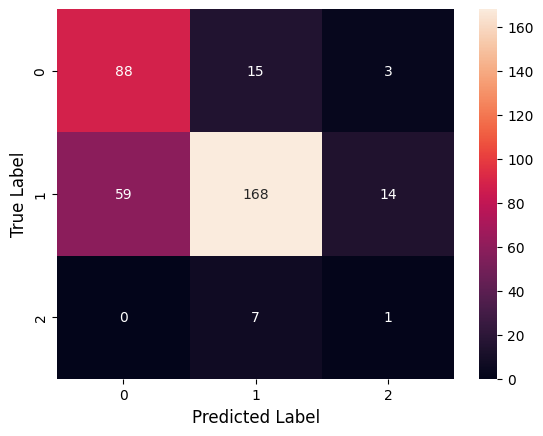

In [360]:
#plot inter
sns.heatmap(confusion_matrix_res_inter, annot=True, fmt="d")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)
plt.savefig('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/confusion_matrix_res_inter.png')
plt.show()

In [361]:
#inter
print('inter')
print(classification_report(test_inter_set.classes, y_pred_inter, labels = [0, 1,2],digits=4))

inter
              precision    recall  f1-score   support

           0     0.5986    0.8302    0.6957       106
           1     0.8842    0.6971    0.7796       241
           2     0.0556    0.1250    0.0769         8

    accuracy                         0.7239       355
   macro avg     0.5128    0.5508    0.5174       355
weighted avg     0.7803    0.7239    0.7387       355



In [362]:
print('inter')
inter = calculate_metrics(confusion_matrix_res_inter)
with open('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/inter.txt', 'w') as f:
    f.write(str(inter))

inter
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Class  |         SE         |         SP         |         AS         |         HS         |       Score        |
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Normal | 0.8301886792452831 | 0.6970954356846473 | 0.7636420574649652 | 0.7578429362312897 | 0.7607424968481274 |
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+


In [363]:
# Calculate sensitivity and specificity for each class
sensitivity_list = []
specificity_list = []
# Calculate sensitivity and specificity for each class
for i in range(3):
    TP = confusion_matrix_res_inter[i, i]
    TN = np.sum(confusion_matrix_res_inter) - np.sum(confusion_matrix_res_inter[i, :]) - np.sum(confusion_matrix_res_inter[:, i]) + confusion_matrix_res_inter[
        i, i]
    FP = np.sum(confusion_matrix_res_inter[:, i]) - confusion_matrix_res_inter[i, i]
    FN = np.sum(confusion_matrix_res_inter[i, :]) - confusion_matrix_res_inter[i, i]

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")

# Calculate macro-averaged sensitivity and specificity
macro_sensitivity = np.mean(sensitivity_list)
macro_specificity = np.mean(specificity_list)
print(f"Macro-averaged Sensitivity = {macro_sensitivity:.4f}, Macro-averaged Specificity = {macro_specificity:.4f}")

Class 0: Sensitivity = 0.8302, Specificity = 0.7631
Class 1: Sensitivity = 0.6971, Specificity = 0.8070
Class 2: Sensitivity = 0.1250, Specificity = 0.9510
Macro-averaged Sensitivity = 0.5508, Macro-averaged Specificity = 0.8404


(355, 3)
(355, 3)


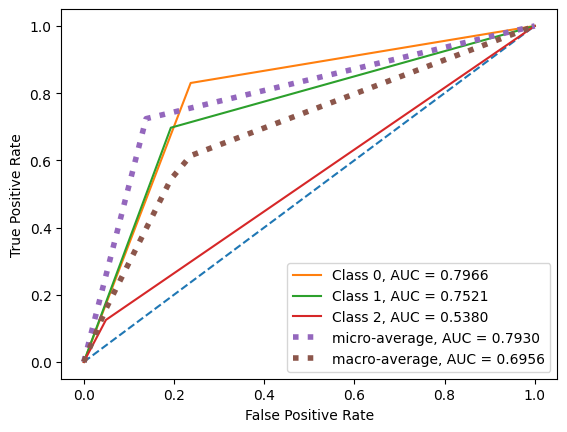

In [364]:
from sklearn.preprocessing import label_binarize
# Binarize true labels for multi-class classification
y_true_binary = label_binarize(test_inter_set.classes, classes=[0, 1, 2])
y_pred = label_binarize(y_pred_inter, classes=[0, 1, 2])
print(y_true_binary.shape)
print(y_pred.shape)
# Calculate ROC curve and AUC for each class
# Calculate ROC curve and AUC for each class
n_classes = 3  # replace with the actual number of classes in your problem
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC
# For macro-average, we average the ROC curve across all classes
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 3
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curve for each class and micro/macro average
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--')
for i in range(3):
    ax.plot(fpr[i], tpr[i], label=f"Class {i}, AUC = {roc_auc[i]:.4f}")
ax.plot(fpr["micro"], tpr["micro"], label="micro-average, AUC = {:.4f}".format(roc_auc["micro"]), linestyle=':', linewidth=4)
ax.plot(fpr["macro"], tpr["macro"], label="macro-average, AUC = {:.4f}".format(roc_auc["macro"]), linestyle=':', linewidth=4)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.savefig('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/ROC curve inter.png')
plt.show()



*   intra


In [365]:
# test evaluation INTRA
with tf.device(device_name):
  print('TEST INTRA')
  test_loss_a, test_acc_a = model.evaluate(test_intra_set)
  print('Test intra accuracy:', test_acc_a)
  print('Test intra loss:', test_loss_a)

TEST INTRA
379/379 [==============================] - 4s 11ms/step - loss: 3.5447 - acc: 0.6834
Test intra accuracy: 0.6833773255348206
Test intra loss: 3.5447494983673096


In [366]:
# test prediction INTRA
with tf.device(device_name):
  test_intra_set.reset()
  Y_pred_intra = model.predict(test_intra_set)
  y_pred_intra = np.argmax(Y_pred_intra, axis=1)

379/379 [==============================] - 4s 10ms/step


In [367]:
#confusion mat intra
confusion_matrix_res_intra  = confusion_matrix(test_intra_set.classes, y_pred_intra)

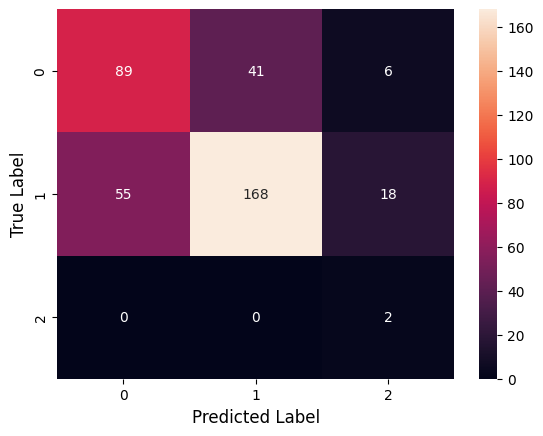

In [368]:
#plot intra
sns.heatmap(confusion_matrix_res_intra, annot=True, fmt="d")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)
plt.savefig('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/confusion_matrix_res_intra.png')
plt.show()

In [369]:
#intra
print('intra')
print(classification_report(test_intra_set.classes, y_pred_intra, labels = [0, 1,2],digits=4))

intra
              precision    recall  f1-score   support

           0     0.6181    0.6544    0.6357       136
           1     0.8038    0.6971    0.7467       241
           2     0.0769    1.0000    0.1429         2

    accuracy                         0.6834       379
   macro avg     0.4996    0.7838    0.5084       379
weighted avg     0.7333    0.6834    0.7037       379



In [370]:
print('intra')
intra = calculate_metrics(confusion_matrix_res_intra)
with open('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/intra.txt', 'w') as f:
    f.write(str(intra))

intra
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Class  |         SE         |         SP         |         AS         |         HS         |       Score        |
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Normal | 0.6544117647058824 | 0.6970954356846473 | 0.6757536001952649 | 0.6750795764950221 | 0.6754165883451435 |
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+


In [371]:
# Calculate sensitivity and specificity for each class
sensitivity_list = []
specificity_list = []
# Calculate sensitivity and specificity for each class
for i in range(3):
    TP = confusion_matrix_res_intra[i, i]
    TN = np.sum(confusion_matrix_res_intra) - np.sum(confusion_matrix_res_intra[i, :]) - np.sum(confusion_matrix_res_intra[:, i]) + confusion_matrix_res_intra[
        i, i]
    FP = np.sum(confusion_matrix_res_intra[:, i]) - confusion_matrix_res_intra[i, i]
    FN = np.sum(confusion_matrix_res_intra[i, :]) - confusion_matrix_res_intra[i, i]

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")

# Calculate macro-averaged sensitivity and specificity
macro_sensitivity = np.mean(sensitivity_list)
macro_specificity = np.mean(specificity_list)
print(f"Macro-averaged Sensitivity = {macro_sensitivity:.4f}, Macro-averaged Specificity = {macro_specificity:.4f}")

Class 0: Sensitivity = 0.6544, Specificity = 0.7737
Class 1: Sensitivity = 0.6971, Specificity = 0.7029
Class 2: Sensitivity = 1.0000, Specificity = 0.9363
Macro-averaged Sensitivity = 0.7838, Macro-averaged Specificity = 0.8043


(379, 3)
(379, 3)


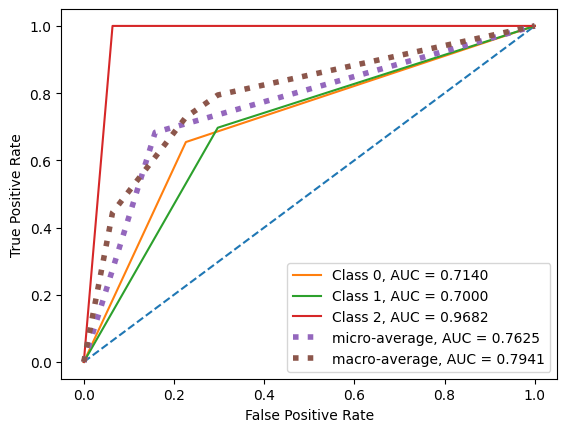

In [372]:
from sklearn.preprocessing import label_binarize
# Binarize true labels for multi-class classification
y_true_binary = label_binarize(test_intra_set.classes, classes=[0, 1, 2])
y_pred = label_binarize(y_pred_intra, classes=[0, 1, 2])
print(y_true_binary.shape)
print(y_pred.shape)
# Calculate ROC curve and AUC for each class
# Calculate ROC curve and AUC for each class
n_classes = 3  # replace with the actual number of classes in your problem
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC
# For macro-average, we average the ROC curve across all classes
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 3
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curve for each class and micro/macro average
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--')
for i in range(3):
    ax.plot(fpr[i], tpr[i], label=f"Class {i}, AUC = {roc_auc[i]:.4f}")
ax.plot(fpr["micro"], tpr["micro"], label="micro-average, AUC = {:.4f}".format(roc_auc["micro"]), linestyle=':', linewidth=4)
ax.plot(fpr["macro"], tpr["macro"], label="macro-average, AUC = {:.4f}".format(roc_auc["macro"]), linestyle=':', linewidth=4)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.savefig('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/ROC curve intra.png')
plt.show()



*   Merged test intra & inter



In [373]:
test_df = [test_intra_df , test_inter_df ]
test_df = pd.concat(test_df)

In [374]:
test_set = test_datagen.flow_from_dataframe(
            test_df,
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            class_mode = 'categorical',
            batch_size = 1,
            shuffle = False)

Found 734 validated image filenames belonging to 3 classes.


In [375]:
with tf.device(device_name):
  test_loss, test_acc = model.evaluate(test_set)
  print('Test intra accuracy:', test_acc)
  print('Test intra loss:', test_loss)

734/734 [==============================] - 8s 10ms/step - loss: 3.5984 - acc: 0.7030
Test intra accuracy: 0.7029972672462463
Test intra loss: 3.5983972549438477


In [376]:
with tf.device(device_name):
  test_set.reset()
  Y_pred = model.predict(test_set)
  y_pred = np.argmax(Y_pred, axis=1)

734/734 [==============================] - 7s 9ms/step


In [377]:
confusion_matrix_res  = confusion_matrix(test_set.classes, y_pred)

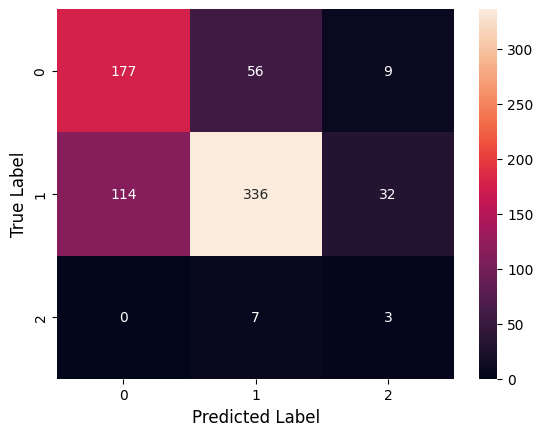

In [378]:
sns.heatmap(confusion_matrix_res, annot=True, fmt="d")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)
plt.savefig('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/confusion_matrix_res.png')
plt.show()

In [379]:
print(classification_report(test_set.classes, y_pred, labels = [0, 1,2],digits=4))

              precision    recall  f1-score   support

           0     0.6082    0.7314    0.6642       242
           1     0.8421    0.6971    0.7628       482
           2     0.0682    0.3000    0.1111        10

    accuracy                         0.7030       734
   macro avg     0.5062    0.5762    0.5127       734
weighted avg     0.7545    0.7030    0.7214       734



In [380]:
all = calculate_metrics(confusion_matrix_res)
with open('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/inter-intra.txt', 'w') as f:
    f.write(str(all))

+--------+-------------------+--------------------+--------------------+--------------------+--------------------+
| Class  |         SE        |         SP         |         AS         |         HS         |       Score        |
+--------+-------------------+--------------------+--------------------+--------------------+--------------------+
| Normal | 0.731404958677686 | 0.6970954356846473 | 0.7142501971811666 | 0.7138381765150698 | 0.7140441868481182 |
+--------+-------------------+--------------------+--------------------+--------------------+--------------------+


In [381]:
# Calculate sensitivity and specificity for each class
sensitivity_list = []
specificity_list = []
# Calculate sensitivity and specificity for each class
for i in range(3):
    TP = confusion_matrix_res[i, i]
    TN = np.sum(confusion_matrix_res) - np.sum(confusion_matrix_res[i, :]) - np.sum(confusion_matrix_res[:, i]) + confusion_matrix_res[
        i, i]
    FP = np.sum(confusion_matrix_res[:, i]) - confusion_matrix_res[i, i]
    FN = np.sum(confusion_matrix_res[i, :]) - confusion_matrix_res[i, i]

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")

# Calculate macro-averaged sensitivity and specificity
macro_sensitivity = np.mean(sensitivity_list)
macro_specificity = np.mean(specificity_list)
print(f"Macro-averaged Sensitivity = {macro_sensitivity:.4f}, Macro-averaged Specificity = {macro_specificity:.4f}")

Class 0: Sensitivity = 0.7314, Specificity = 0.7683
Class 1: Sensitivity = 0.6971, Specificity = 0.7500
Class 2: Sensitivity = 0.3000, Specificity = 0.9434
Macro-averaged Sensitivity = 0.5762, Macro-averaged Specificity = 0.8206


(734, 3)
(734, 3)


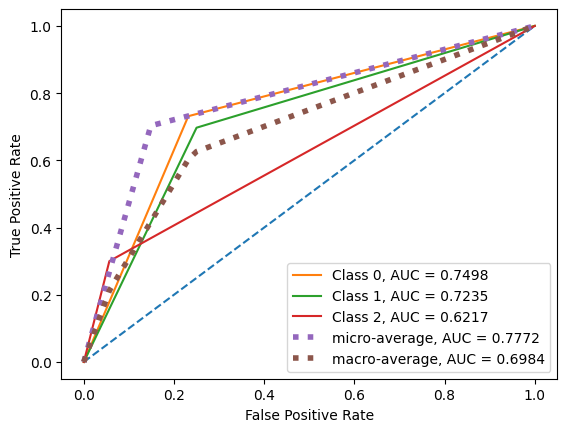

In [382]:
from sklearn.preprocessing import label_binarize
# Binarize true labels for multi-class classification
y_true_binary = label_binarize(test_set.classes, classes=[0, 1, 2])
y_pred = label_binarize(y_pred, classes=[0, 1, 2])
print(y_true_binary.shape)
print(y_pred.shape)
# Calculate ROC curve and AUC for each class
# Calculate ROC curve and AUC for each class
n_classes = 3  # replace with the actual number of classes in your problem
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC
# For macro-average, we average the ROC curve across all classes
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 3
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curve for each class and micro/macro average
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--')
for i in range(3):
    ax.plot(fpr[i], tpr[i], label=f"Class {i}, AUC = {roc_auc[i]:.4f}")
ax.plot(fpr["micro"], tpr["micro"], label="micro-average, AUC = {:.4f}".format(roc_auc["micro"]), linestyle=':', linewidth=4)
ax.plot(fpr["macro"], tpr["macro"], label="macro-average, AUC = {:.4f}".format(roc_auc["macro"]), linestyle=':', linewidth=4)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.savefig('/content/drive/MyDrive/models (3 calsses)/Audio tests /Batches/8/ROC curve all.png')
plt.show()